# **1. Install Dependencies**
Install the required libraries for TensorFlow, OpenCV, and Matplotlib.


In [2]:
!pip install tensorflow opencv-python matplotlib


# Set Up GPU Configuration
If a GPU is available, configure it to optimize memory usage.



In [3]:
import tensorflow as tf
import os

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Download the Dataset
We will use `kagglehub` to download the dataset. This step retrieves the dataset and moves it to the appropriate directory.


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aravindanr22052001/emotiondetection-happy-or-sad")

print("Path to dataset files:", path)

100%|██████████| 64.8M/64.8M [00:00<00:00, 121MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/aravindanr22052001/emotiondetection-happy-or-sad/versions/1


In [6]:
!mv {path + "/data"} .

# Validate and Clean the Images
We will validate each image to ensure it belongs to one of the valid formats (`jpeg`, `jpg`, `bmp`, `png`). Any invalid images will be removed.



In [7]:
import cv2
import imghdr

In [8]:
data_dir = 'data'

In [9]:
image_ext = ['jpeg', 'jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)  # Validate the image type
            if tip not in image_ext:
                print(f"Image not in ext list: {image_path}")
                os.remove(image_path)
        except Exception as e:
            print(f"Issue with image {image_path}: {e}")

Image not in ext list: data/sad/cry-360x240.gif
Image not in ext list: data/sad/african-american-depressive-sad-broken-260nw-475790911.jpg
Image not in ext list: data/sad/sad-people-group-therapy-session_23-2148752071.jpg
Image not in ext list: data/sad/sad-people-chairs-group-therapy-session_23-2148752072.jpg
Image not in ext list: data/sad/5cd731f92100002f007a7304.jpeg
Image not in ext list: data/sad/depressed-man-studio-shot-260nw-404652526.jpg
Image not in ext list: data/sad/2560px-Sad-Mental-Illness.jpg
Image not in ext list: data/sad/secret-signs-of-loneliness-01-1440x810.jpg
Image not in ext list: data/sad/44861512-smiling-man-in-a-crowd-of-sad-people.jpg
Image not in ext list: data/sad/14HRhniN7B7Fqx5GCoFpQ3A.jpeg
Image not in ext list: data/sad/1800x1200_visual_guide_to_seasonal_affective_disorder_sad_slideshow.jpg
Image not in ext list: data/sad/50740738-portrC3A4ts-der-traurige-menschen.jpg
Image not in ext list: data/happy/o-HAPPY-facebook.jpg
Image not in ext list: data/ha

# Load the Dataset and Visualize Samples
The dataset is loaded, and we display a few sample images for inspection.

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')


Found 148 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator();

In [14]:
batch = data_iterator.next()

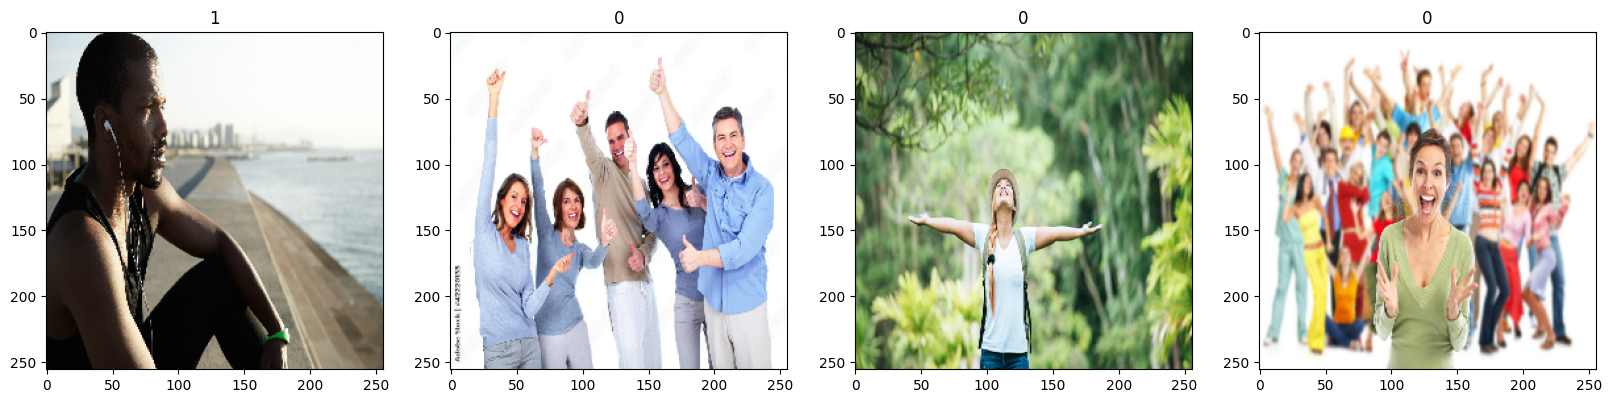

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Normalize the Dataset
The dataset is normalized by dividing pixel values by 255, converting them into a range between 0 and 1.


In [17]:
data = data.map(lambda x, y: (x/255, y))

In [18]:
len(data)

5

# Split the Dataset into Training, Validation, and Test Sets
We split the dataset into training (70%), validation (10%), and test (10%) sets.


In [19]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .1) + 1
test_size = int(len(data) * .1)+1

In [20]:
train_size + val_size + test_size

5

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Define the CNN Model
We define a simple CNN architecture for emotion classification.



In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [23]:
model = Sequential()

In [24]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

# Train the Model
Train the model for 20 epochs with the training data. TensorBoard will be used to visualize training progress.


In [27]:
!mkdir logs

In [28]:
logdir ='logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.4727 - loss: 1.6130 - val_accuracy: 0.4688 - val_loss: 1.1244
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - accuracy: 0.4245 - loss: 1.0242 - val_accuracy: 0.7188 - val_loss: 0.5987
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5768 - loss: 0.6497 - val_accuracy: 0.6250 - val_loss: 0.5824
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.4948 - loss: 0.7115 - val_accuracy: 0.5000 - val_loss: 0.6847
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6380 - loss: 0.6429 - val_accuracy: 0.5938 - val_loss: 0.6366
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5260 - loss: 0.6558 - val_accuracy: 0.8750 - val_loss: 0.5571
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7760 - loss: 0.6002 - val_accuracy: 0.8125 - val_loss: 0.5434
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7279 - loss: 0.5668 - val_accuracy: 0.7188 - val_loss: 0.4995
Epoch 9/20
3/3 

# Plot Loss and Accuracy Curves
Plot the loss and accuracy curves for training and validation data.

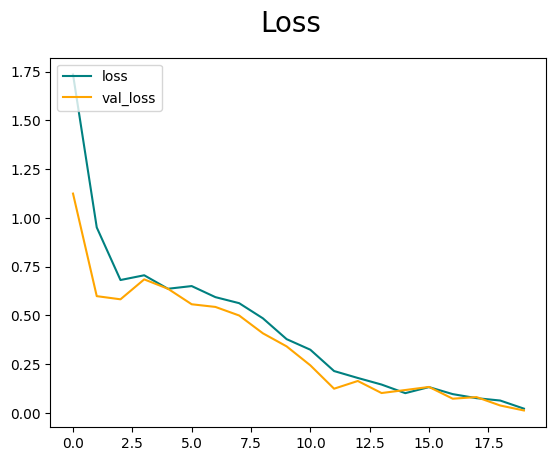

In [33]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

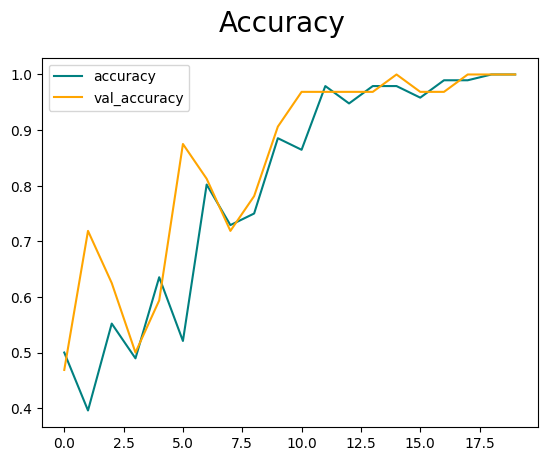

In [34]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate the Model on Test Data
We evaluate the model on the test dataset using precision, recall, and accuracy metrics.

In [35]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [36]:
precison = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = model.predict(X)
  precison.update_state(y, yhat)
  recall.update_state(y, yhat)
  accuracy.update_state(y, yhat)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step


In [39]:
print(f"Precision: {precison.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


# Save the Model
Save the trained model to the `models` directory for future use.

In [41]:
from tensorflow.keras.models import load_model


In [40]:
!mkdir models

In [42]:
model.save(os.path.join('models', 'imageclassifier.h5'))